In [1]:
from __future__ import print_function, division
import os, bz2, json, time
from datetime import timedelta

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import my_util

In [2]:
categories = ["activism","autos","comedy","education","entertainment", \
              "film","gaming","howto","movies","music","news","people", \
              "pets","science","shows","sports","trailers","travel"]

In [3]:
dataset_base = "G:/MLCV dataset/engagement'16/tweeted_videos" 
# dataset_base = "G:/MLCV dataset/engagement'16/quality_videos"
test_category = categories[17]
# test_category = "movies"
# test_category = "vevo"

with open(os.path.join(dataset_base, test_category+".json"), "r") as f:
    dataset_json = f.readlines()

#### Preprocess dataset

In [4]:
eval_days = [90, 135, 180, 225, 270]

In [5]:
# dict-like dataset
dataset = {}
# attributes
vids_set = set()
vids = []
days = []
views = []
shares = []
watches = []
for line in dataset_json:
    record = json.loads(line)
    try:
        category_id = int(record['snippet']['categoryId'])
        day = [int(x) for x in record['insights']['days'].split(",")]
        """!!!"""
        if len(day) < eval_days[-1]: continue
        """!!!"""
        view = [int(x) for x in record['insights']['dailyView'].split(",")]
        share = [int(x) for x in record['insights']['dailyShare'].split(",")]
        watch = [float(x) for x in record['insights']['dailyWatch'].split(",")]
    except:
        continue
    dataset[record['id']] = (category_id, day, view, share, watch)
    
    if record['id'] in vids_set:
        continue
    vids_set.add(record['id'])
    
    vids.append(record['id'])
    days.append(day)
    views.append(view)
    shares.append(share)
    watches.append(watch)
print("dataset size:", len(vids))

dataset size: 12921


#### Stats

In [6]:
print("Min days",np.min([len(x) for x in days]))
print("Max days",np.max([len(x) for x in days]))
print("Average days",np.average([len(x) for x in days]))

Min days 270
Max days 328
Average days 289.59082114387434


#### Analysis

In [7]:
# df_total_views_no_filter = my_util.total_at_no_filter(eval_days, views, vids, accumulate=True)
# pop_percs = my_util.pop_perc_at(eval_days, views, vids, accumulate=True)

In [8]:
# total_views_binned = my_util.plot_popPerc_totalViews(eval_days[:2], df_total_views_no_filter, pop_percs)

In [9]:
df_total_views = my_util.total_at(eval_days, views, vids, accumulate=False)
df_total_views_log = my_util.total_log_at(eval_days, views, vids, accumulate=False)

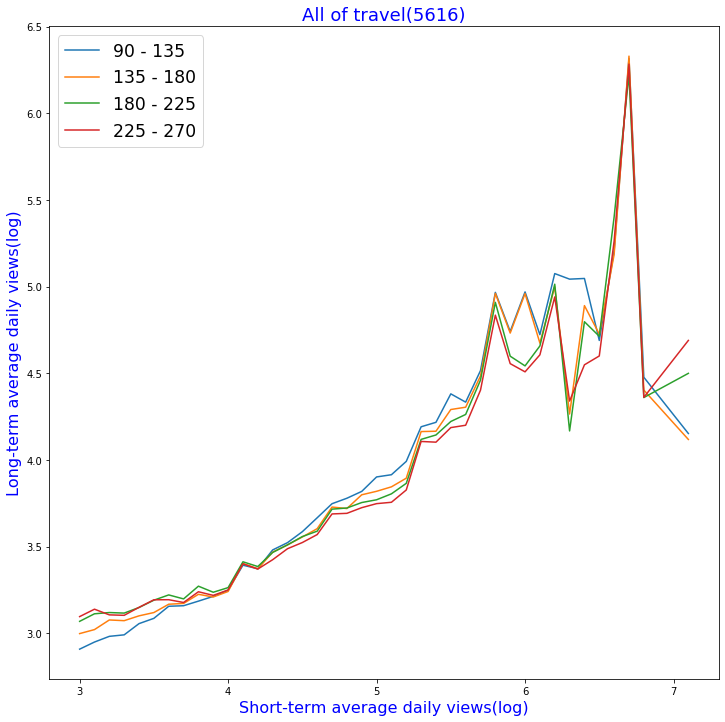

In [10]:
my_util.plot_fixed_window(eval_days, df_total_views_log, test_category)